# <p style="background-color: #780000; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:5px 10px; padding: 20px"> Cybersecurity Intrusion and Anomaly detection</p>

<div style="border-radius:10px; padding: 15px; background-color: #fdf0d5; font-size:120%; text-align:left; ">  
    
## Objective 

 - Detect cyber intrusions based on network traffic and user behavior.  
 - Identify anomalies using autoencoders and classify them as potential threats.  
 - Optimize model performance using GridSearchCV for best hyperparameters.  

## Overview
 - Performed Exploratory Data Analysis (EDA) to understand network traffic patterns.
 - Balanced the dataset to address class imbalance for better model performance.
 - Detected anomalies using autoencoders and classified them using multiple models.
 - Tuned hyperparameters using GridSearchCV to improve detection accuracy.  



### <span style= color:#c1121f;> Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/cybersecurity-intrusion-detection-dataset/cybersecurity_intrusion_data.csv


### <span style= color:#c1121f;> Style

In [2]:
colors = ['#780000', '#c1121f', '#fdf0d5', '#003049', '#669bbc']
sns.set_theme(style="darkgrid", rc={'axes.facecolor': colors[2]})

### <span style= color:#c1121f;> Import Data

In [3]:
df = pd.read_csv("/kaggle/input/cybersecurity-intrusion-detection-dataset/cybersecurity_intrusion_data.csv")

# <p style="background-color:#c1121f; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:5px 10px; padding: 20px">DataOverview</p>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


In [5]:
#percentage of missing data
no_of_values = df.shape[0]  
temp = df.isnull().sum()  
temp = (temp / no_of_values) * 100  
print(temp)


session_id              0.000000
network_packet_size     0.000000
protocol_type           0.000000
login_attempts          0.000000
session_duration        0.000000
encryption_used        20.614449
ip_reputation_score     0.000000
failed_logins           0.000000
browser_type            0.000000
unusual_time_access     0.000000
attack_detected         0.000000
dtype: float64


### <span style= color:#c1121f;> Handling Missing data

In [6]:
df["encryption_used"].unique()

array(['DES', 'AES', nan], dtype=object)

In [7]:
df["encryption_used"] = df["encryption_used"].fillna(value="No_enc")
df.isnull().sum()

session_id             0
network_packet_size    0
protocol_type          0
login_attempts         0
session_duration       0
encryption_used        0
ip_reputation_score    0
failed_logins          0
browser_type           0
unusual_time_access    0
attack_detected        0
dtype: int64

## <span style= color:#c1121f;> Exploratory data Analysis

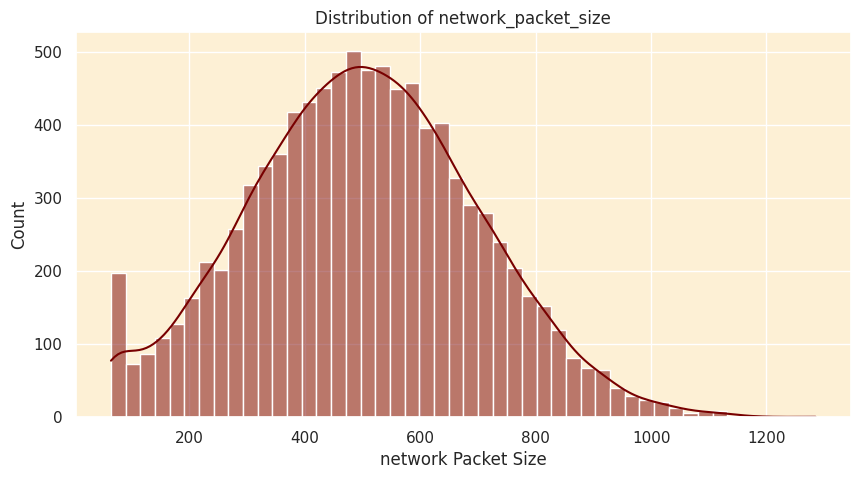

In [8]:
plt.figure(figsize=(10,5))
sns.histplot(df["network_packet_size"],kde=True,color=colors[0])
plt.xlabel("network Packet Size")
plt.ylabel("Count")
plt.title("Distribution of network_packet_size")
plt.show()

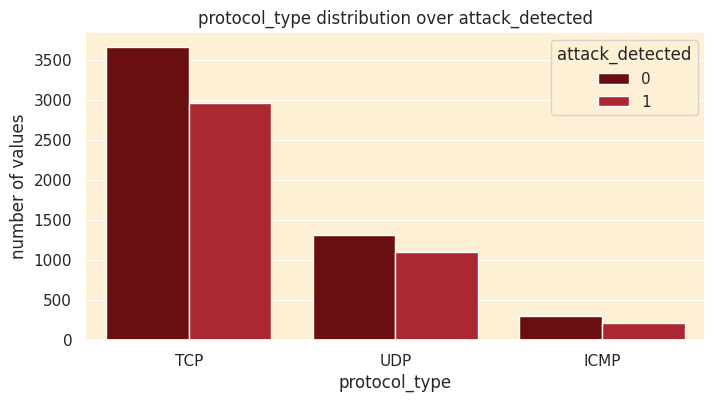

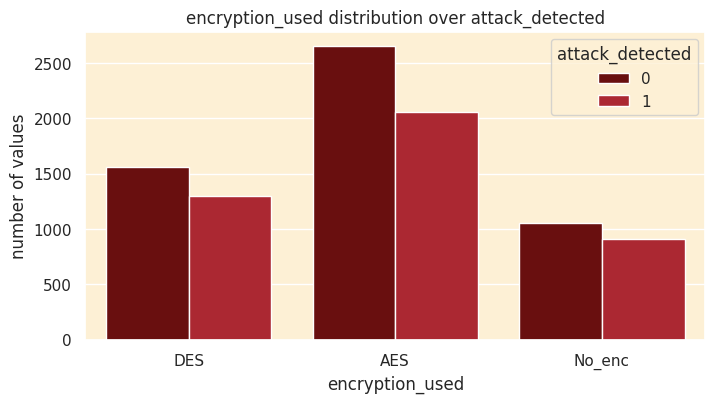

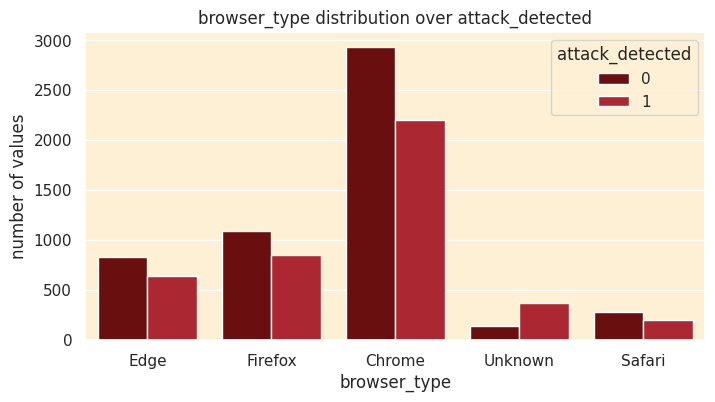

In [9]:
obj_col = df.select_dtypes(include="object")
obj_col.drop(columns=["session_id"],inplace=True)
for c in obj_col.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df,x=c,hue='attack_detected',palette=colors)
    plt.xlabel(c)
    plt.ylabel("number of values")
    plt.title(f"{c} distribution over attack_detected")
    plt.show()



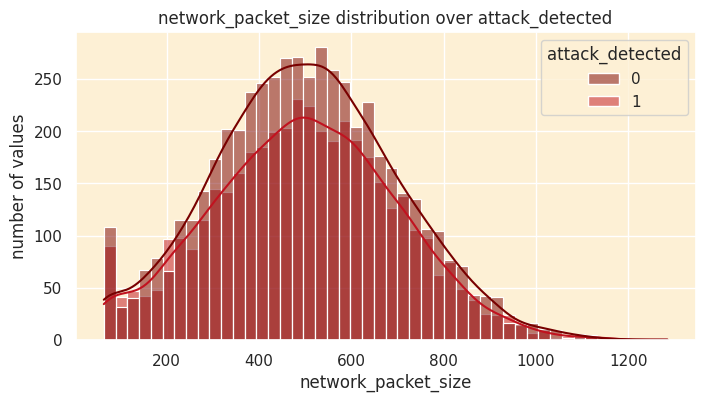

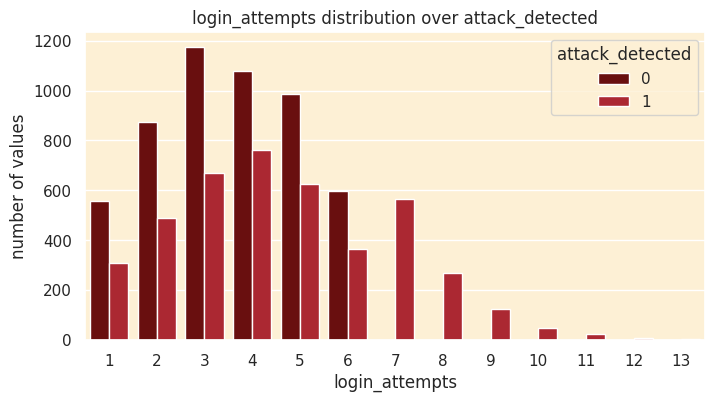

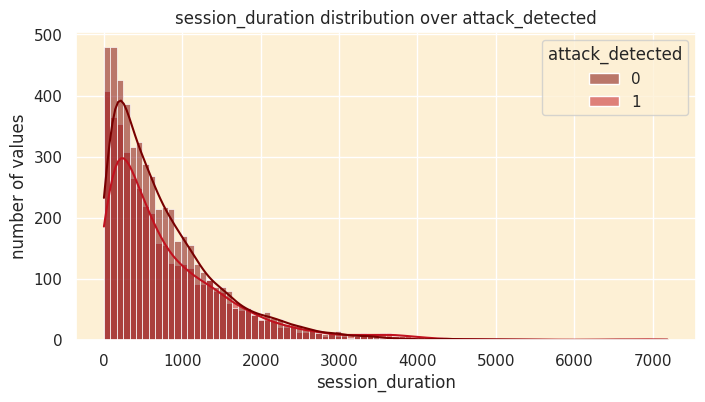

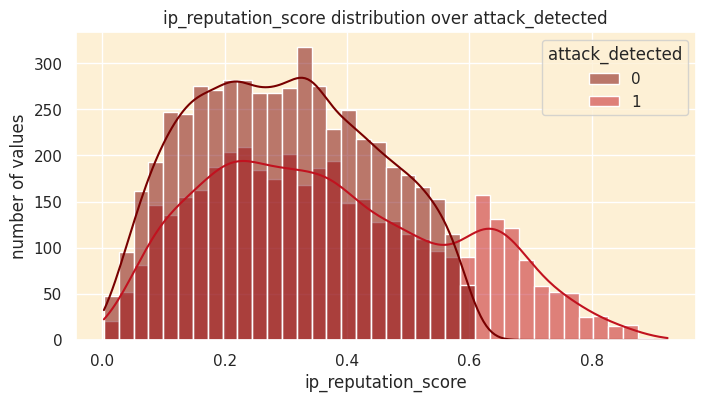

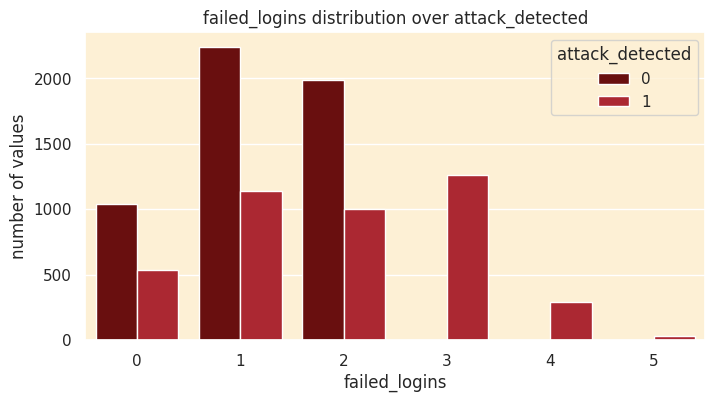

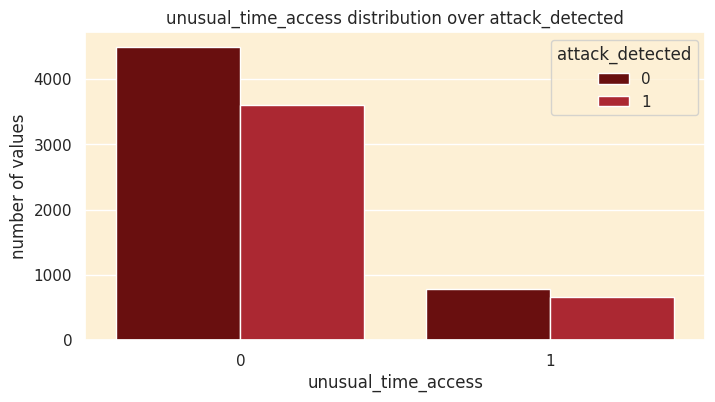

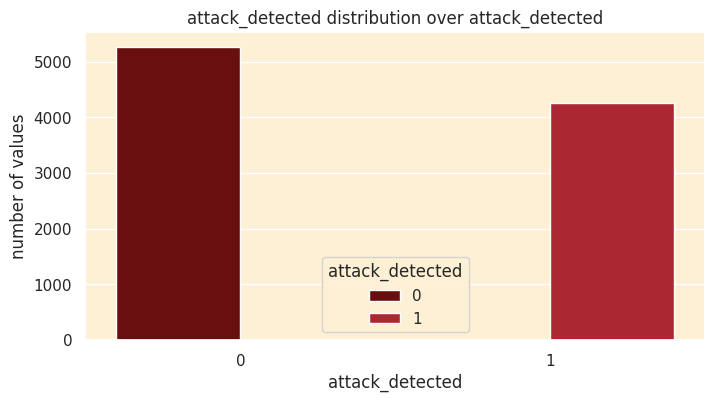

In [10]:
num_col = df.select_dtypes(include=["float64","int64"])
for c in num_col.columns:
    plt.figure(figsize=(8,4))
    if num_col[c].nunique() >15:
        sns.histplot(data=num_col,x=c,hue='attack_detected',kde=True,palette=colors)
    else:
        sns.countplot(data=num_col,x=c,hue="attack_detected",palette=colors)
    plt.xlabel(c)
    plt.ylabel("number of values")
    plt.title(f"{c} distribution over attack_detected")
    plt.show()



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      9537 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


### <span style= color:#c1121f;> Lable Encoding

In [12]:
df = pd.get_dummies(df,columns=["protocol_type","encryption_used","browser_type"], drop_first=False,dtype=int)

In [13]:
df.head()

,session_id,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected,protocol_type_ICMP,protocol_type_TCP,protocol_type_UDP,encryption_used_AES,encryption_used_DES,encryption_used_No_enc,browser_type_Chrome,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown
0,SID_00001,599,4,492.983263,0.606818,1,0,1,0,1,0,0,1,0,0,1,0,0,0
1,SID_00002,472,3,1557.996461,0.301569,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,SID_00003,629,3,75.044262,0.739164,2,0,1,0,1,0,0,1,0,1,0,0,0,0
3,SID_00004,804,4,601.248835,0.123267,0,0,1,0,0,1,0,1,0,0,0,0,0,1
4,SID_00005,453,5,532.540888,0.054874,1,0,0,0,1,0,1,0,0,0,0,1,0,0


In [14]:
df.drop(columns=["session_id"],inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   network_packet_size     9537 non-null   int64  
 1   login_attempts          9537 non-null   int64  
 2   session_duration        9537 non-null   float64
 3   ip_reputation_score     9537 non-null   float64
 4   failed_logins           9537 non-null   int64  
 5   unusual_time_access     9537 non-null   int64  
 6   attack_detected         9537 non-null   int64  
 7   protocol_type_ICMP      9537 non-null   int64  
 8   protocol_type_TCP       9537 non-null   int64  
 9   protocol_type_UDP       9537 non-null   int64  
 10  encryption_used_AES     9537 non-null   int64  
 11  encryption_used_DES     9537 non-null   int64  
 12  encryption_used_No_enc  9537 non-null   int64  
 13  browser_type_Chrome     9537 non-null   int64  
 14  browser_type_Edge       9537 non-null   

### <span style= color:#c1121f;> Correlation Matrix

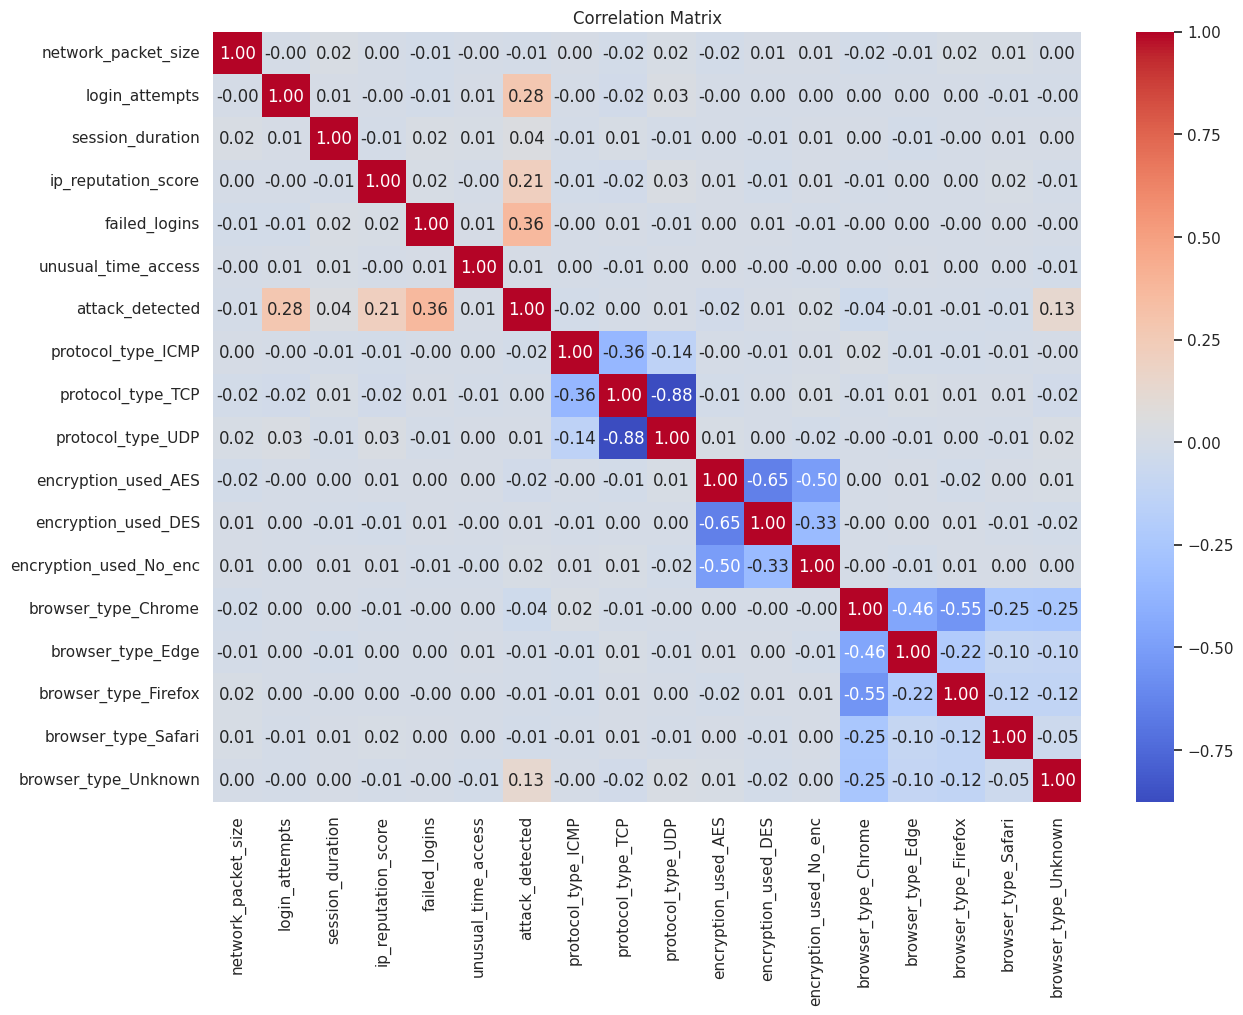

In [16]:
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

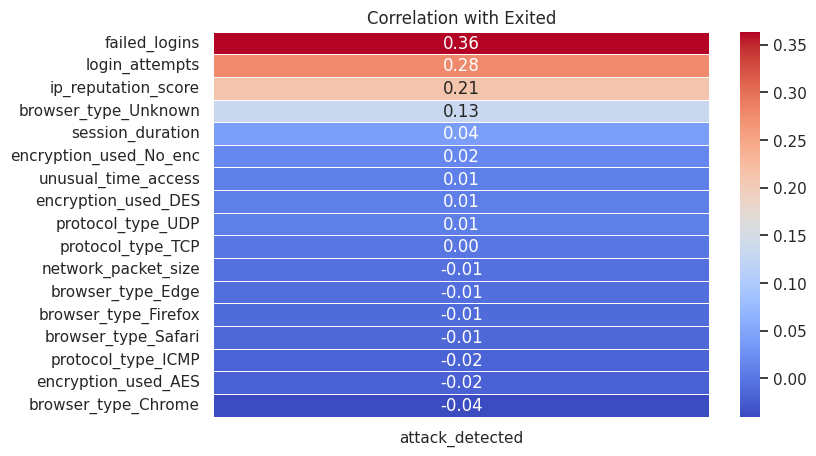

In [17]:
correlation_matrix = df.corr()

correlation_price = correlation_matrix['attack_detected'].sort_values(ascending=False).drop("attack_detected")

# Plot the heatmap for the correlation with 'Exited'
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_price.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation with Exited')
plt.show()

### <span style= color:#c1121f;> Future selection using Random Forest

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
X = df.drop(columns=['attack_detected'])
y = df['attack_detected']

In [19]:
print("Shape for X Dataframe: ", X.shape)
print("Columns for X Dataframe: ", X.columns)
print("-"*50)
print("Shape for y Dataframe: ", y.shape)

Shape for X Dataframe:  (9537, 17)
Columns for X Dataframe:  Index(['network_packet_size', 'login_attempts', 'session_duration',
       'ip_reputation_score', 'failed_logins', 'unusual_time_access',
       'protocol_type_ICMP', 'protocol_type_TCP', 'protocol_type_UDP',
       'encryption_used_AES', 'encryption_used_DES', 'encryption_used_No_enc',
       'browser_type_Chrome', 'browser_type_Edge', 'browser_type_Firefox',
       'browser_type_Safari', 'browser_type_Unknown'],
      dtype='object')
--------------------------------------------------
Shape for y Dataframe:  (9537,)


In [20]:
# Train the model
rf.fit(X, y)

RandomForestClassifier(random_state=42)

In [21]:
# Get feature importances
feature_importances = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['importance'])
feature_importances = feature_importances.sort_values('importance', ascending=False)

<Figure size 1200x800 with 0 Axes>

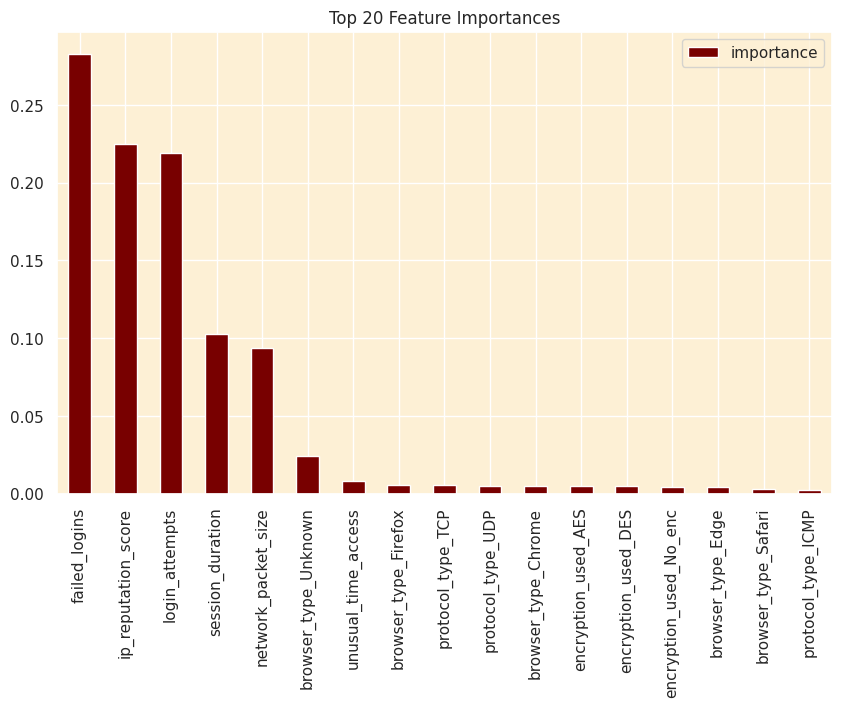

In [22]:
# Plot feature importances
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar', figsize=(10, 6),color=colors)
plt.title("Top 20 Feature Importances")
plt.show()

In [23]:
important_features = feature_importances.head(5).index

In [24]:
fliter_df = df[important_features ]
fliter_df.head()

,failed_logins,ip_reputation_score,login_attempts,session_duration,network_packet_size
0,1,0.606818,4,492.983263,599
1,0,0.301569,3,1557.996461,472
2,2,0.739164,3,75.044262,629
3,0,0.123267,4,601.248835,804
4,1,0.054874,5,532.540888,453


In [25]:
fliter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   failed_logins        9537 non-null   int64  
 1   ip_reputation_score  9537 non-null   float64
 2   login_attempts       9537 non-null   int64  
 3   session_duration     9537 non-null   float64
 4   network_packet_size  9537 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 372.7 KB


In [26]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 9537 entries, 0 to 9536
Series name: attack_detected
Non-Null Count  Dtype
--------------  -----
9537 non-null   int64
dtypes: int64(1)
memory usage: 74.6 KB


### <span style= color:#c1121f;> Normalization

In [27]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(fliter_df)

## <p style="background-color:#c1121f; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:5px 10px; padding: 20px">Autoencoder Anomaly detection</p>

In [28]:
# Split into training (only normal data) and test sets
X_train = X_scaled[y == 0]  # Normal sessions only
X_test = X_scaled  # Full dataset

In [29]:
# Autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 3 # Compressed representation

encoder = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=(input_dim,)),
    layers.Dense(encoding_dim, activation='relu')
])

decoder = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=(encoding_dim,)),
    layers.Dense(input_dim, activation='sigmoid')
])

autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')

In [30]:
# Train autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=1)

# Compute reconstruction errors
X_test_pred = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.abs(X_test - X_test_pred), axis=1)


Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0796 - val_loss: 0.0383
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0236 - val_loss: 0.0319
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0202 - val_loss: 0.0260
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0164 - val_loss: 0.0215
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143 - val_loss: 0.0200
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0192
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0189
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0122 - val_loss: 0.0187
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0186
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0119 - val_loss: 0.0184
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0184
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [31]:
# Set anomaly threshold 
threshold = np.percentile(reconstruction_errors, 75)


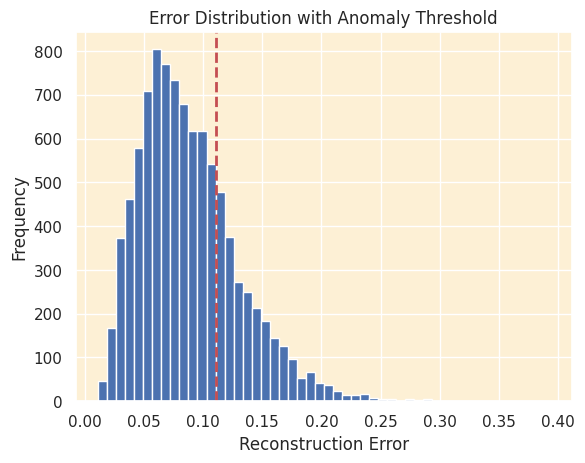

In [32]:
# Detect anomalies
y_pred = reconstruction_errors > threshold

df_results = df.copy()
df_results["anomaly_score"] = reconstruction_errors
df_results["predicted_attack"] = y_pred.astype(int)

# Plot error distribution
plt.hist(reconstruction_errors, bins=50)
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2,)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution with Anomaly Threshold")
plt.show()

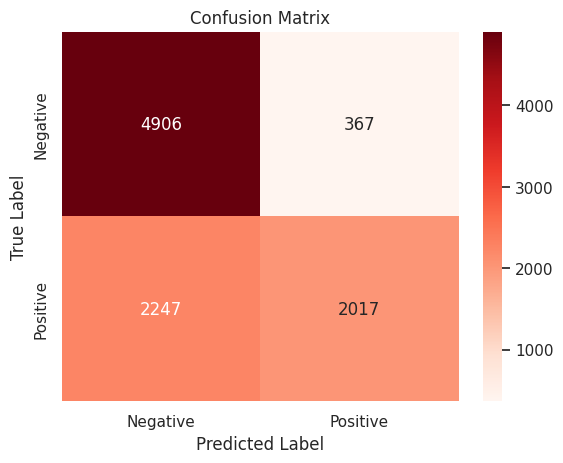

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.93      0.79      5273
           1       0.85      0.47      0.61      4264

    accuracy                           0.73      9537
   macro avg       0.77      0.70      0.70      9537
weighted avg       0.76      0.73      0.71      9537



In [33]:
# Accuracy Matrix
conf_matrix = confusion_matrix(y, y_pred)
# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

class_report = classification_report(y, y_pred)
print("Classification Report:\n", class_report)

In [34]:
from sklearn.metrics import accuracy_score

accuracy_score(y,y_pred)

0.7259096151829716

# <p style="background-color:#c1121f; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:5px 10px; padding: 20px">ML attack detection using gridsearch</p>

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled , y, test_size=0.2, random_state=42)

In [36]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(),
    'CatBoost': cb.CatBoostClassifier(silent=True),
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'KNN': KNeighborsClassifier()
}

In [37]:
# Define reduced parameter grids
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1],
        'solver': ['liblinear'],
        'penalty': ['l2']
    },
    'Decision Tree': {
        'max_depth': [5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [10],
        'min_samples_split': [2],
        'min_samples_leaf': [1]
    },
    'Gradient Boosting': {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [5]
    },
    'XGBoost': {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [5],
        'subsample': [0.8, 1.0]
    },
    'SVM (RBF)': {
        'C': [1, 10],
        'gamma': ['scale', 'auto']
    },
    'SVM (Linear)': {
        'C': [1, 10],
    },
    'LightGBM': {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3, 5],
    },
    'CatBoost': {
        'iterations': [100],
        'learning_rate': [0.1],
        'depth': [3, 5]
    },
    'KNN': {
        'n_neighbors': [3],
        'weights': ['uniform', 'distance']
    },
    'AdaBoost': {
        'n_estimators': [100],
        'learning_rate': [0.01, 0.1]
    },
    'Bagging': {
        'n_estimators': [100],
        'max_samples': [0.8, 1.0]
    }
}

In [38]:
# Initialize an empty dictionary to store results
model_results = {}

# Handle class imbalance by computing class weights for each model that supports it
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("class_weight_dict: ", class_weight_dict)

class_weight_dict:  {0: 0.901559914913732, 1: 1.1225721012360212}


In [39]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [40]:
# Evaluate models with GridSearchCV
for model_name, model in models.items():
    print(f"\nTraining model with GridSearchCV: {model_name}")

    param_grid = param_grids[model_name]
    
    if model_name in ['Logistic Regression', 'Random Forest', 'SVM (RBF)', 'SVM (Linear)']:
        # Assign class weights for models that support it
        if model_name == 'Logistic Regression':
            model = LogisticRegression(class_weight='balanced')
        elif model_name == 'Random Forest':
            model = RandomForestClassifier(class_weight='balanced')
        elif model_name in ['SVM (RBF)', 'SVM (Linear)']:
            model = SVC(probability=True, class_weight='balanced') if model_name == 'SVM (RBF)' else LinearSVC(class_weight='balanced')


    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
    
    grid_search.fit(X_train_smote, y_train_smote)
    
    # Get the best model and its parameters
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    # Predict on both train and test sets
    y_train_pred = best_model.predict(X_train_smote)
    y_test_pred = best_model.predict(X_test)
    
    # Store the results
    model_results[model_name] = {
        'train_accuracy': best_model.score(X_train_smote, y_train_smote),
        'test_accuracy': best_model.score(X_test, y_test),
        'classification_report': classification_report(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
    }

    # Print results after all models are evaluated
    print("\nModel Evaluation Results:")
    print(f"Train Accuracy: {model_results[model_name]['train_accuracy']:.4f}")
    print(f"Test Accuracy: {model_results[model_name]['test_accuracy']:.4f}")
    print(f"ROC AUC: {model_results[model_name]['roc_auc']:.4f} \n")
    print(f"Classification Report:\n{model_results[model_name]['classification_report']}")
    print("-" * 100)


Training model with GridSearchCV: Logistic Regression
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

Model Evaluation Results:
Train Accuracy: 0.7182
Test Accuracy: 0.7332
ROC AUC: 0.7987 

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.75      1042
           1       0.70      0.71      0.71       866

    accuracy                           0.73      1908
   macro avg       0.73      0.73      0.73      1908
weighted avg       0.73      0.73      0.73      1908

----------------------------------------------------------------------------------------------------

Training model with GridSearchCV: Decision Tree
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Model Evaluation Results:
Train Accuracy: 0.86

<div style="border-radius:10px; padding: 15px; background-color: #fdf0d5; font-size:120%; text-align:left; ">  
    
### **Model Performance Summary:**

| Model               | Train Accuracy | Test Accuracy | ROC AUC |
|---------------------|---------------|--------------|---------|
| Logistic Regression | 0.7182        | 0.7332       | 0.7987  |
| Decision Tree      | 0.8620        | 0.8679       | 0.8773  |
| Random Forest      | 0.8653        | 0.8684       | 0.8728  |
| Gradient Boosting  | 0.8763        | 0.8669       | 0.8779  |
| XGBoost           | 0.8619        | 0.8658       | 0.8799  |
| LightGBM          | 0.8620        | 0.8664       | 0.8750  |

### **Observations:**
1. **Logistic Regression is the weakest performer**, with lower accuracy and ROC AUC compared to tree-based models. This suggests that a linear decision boundary may not be ideal for your dataset.
   
2. **Decision Tree, Random Forest, Gradient Boosting, XGBoost, and LightGBM all perform similarly** in terms of test accuracy (apporx.86.6-86.8%) and ROC AUC (approx 87.2-87.9%). 

3. **Gradient Boosting and XGBoost have the highest ROC AUC (~0.878-0.880), making them the best models for ranking predictions.** 

4. **Overfitting seems minimal**, as the train and test accuracies are quite close for tree-based models.

### **Next Steps:**
- **Feature Importance Analysis:** Identify the most important features using models like Random Forest or XGBoost.
- **Hyperparameter Tuning:** You might explore a broader range of hyperparameters to push performance further.
- **Ensemble Methods:** Combining models (e.g., stacking XGBoost and LightGBM) could further improve performance.
- **Threshold Tuning:** If recall/precision is more critical, fine-tune the decision threshold.
